# Synthetic data test using the CRUST1.0 model and a homogeneous density-contrast

This notebook runs a similar test to [`synthetic-crust1-south-america.ipynb`](synthetic-crust1-south-america.ipynb) using the CRUST1.0 model. But this time we'll use a model with a homogeneous density-contrast along the Moho.

The purpose of this test is to verify if our cross-valiation approach is able to estimate the true values of the reference level and the density-contrast (assuming that it is homogeneous). In the [`synthetic-crust1-south-america.ipynb`](synthetic-crust1-south-america.ipynb) notebook we ran an inversion assuming a homogeneous density-contrast when in fact the true density-contrast varied along the Moho. Thus, we could not verify if our estimate of the density-contrast is correct. For that, we'll need to use a true model with a homogeneous density-contrast.

## Package imports

Load the necessary libraries to run the inversion and make graphs.

In [1]:
# Insert the plots into the notebook
%matplotlib inline

Load the standard scientific Python stack to numerical analysis and plotting.

In [41]:
from __future__ import division
import cPickle as pickle
import itertools
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import multiprocessing
import seaborn  # Makes the default style of the plots nicer

The computations generate a lot of run-time warnings. They aren't anything to be concerned about so disable them to avoid clutter.

In [3]:
import warnings
warnings.simplefilter('ignore')

Load the required modules from [Fatiando a Terra](http://www.fatiando.org).

In [4]:
from fatiando.vis import mpl
from fatiando.gravmag import tesseroid
from fatiando import gridder, utils
from fatiando.inversion import Smoothness2D
import fatiando

In [5]:
print("Version of Fatiando a Terra used: {}".format(fatiando.__version__))

Version of Fatiando a Terra used: 3aed3f5676a45705b598bfc72f9883043097c854


Load our custom classes and functions.

In [6]:
from tesseroid_mesh import TesseroidRelief
from datasets import fetch_assumpcao_moho_points, fetch_crust1
from moho import MohoGravityInvSpherical, cross_validation, make_mesh

Get the number of cores in this computer to run the some things in parallel.

In [7]:
ncpu = multiprocessing.cpu_count()
print("Number of cores: {}".format(ncpu))

Number of cores: 4


## Load the CRUST1 model for South America

Get the CRUST1.0 data from the archive file and cut it to South America.

In [8]:
crust1 = fetch_crust1('../data/crust1.0.tar.gz').cut((-60, 20, -90, -30))

Establish a reference level for the Moho of the Normal Earth (given as height above the ellipsoid in meters, thus it is negative).

In [9]:
reference = -30e3

Make a plot of the Moho depth using an appropriate map projection.

In [10]:
area = crust1.area
bm = Basemap(projection='cyl', 
             llcrnrlon=area[2], urcrnrlon=area[3], llcrnrlat=area[0], urcrnrlat=area[1],
             lon_0=0.5*(area[2] + area[3]), lat_0=0.5*(area[1] + area[0]), 
             resolution='l')

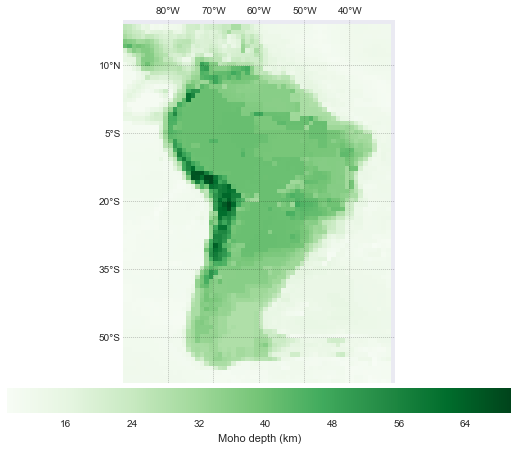

In [11]:
x, y = bm(crust1.lon, crust1.lat)

plt.figure(figsize=(7, 6))
bm.pcolormesh(x, y, 0.001*crust1.moho_depth, cmap='Greens')
plt.colorbar(orientation='horizontal', pad=0.01).set_label('Moho depth (km)')
bm.drawmeridians(np.arange(-80, -30, 10), labels=[0, 0, 1, 0], linewidth=0.2)
bm.drawparallels(np.arange(-50, 30, 15), labels=[1, 0, 0, 0], linewidth=0.2)
plt.tight_layout(pad=0)

## Generate synthetic data

Setup the computation grid using the coordinates of the center of each cell in the model as data points.


In [12]:
lat, lon = crust1.clat.ravel(), crust1.clon.ravel()
shape = crust1.shape
print(shape)
height = 50e3*np.ones_like(lon)

(80, 60)


In [12]:
lat, lon = crust1.clat[::3, ::3], crust1.clon[::3, ::3]
shape = lat.shape
lat, lon = lat.ravel(), lon.ravel()
print(shape)
height = 50e3*np.ones_like(lon)

(27, 20)


Create a `TesseroidRelief` model of the Moho using a homogeneous density-contrast so that we can use in forward modeling.

In [13]:
moho_density_contrast = 350

In [14]:
model = TesseroidRelief(area, crust1.shape, relief=-crust1.moho_depth.ravel(), reference=reference)
density = moho_density_contrast*np.ones(model.size)
density[model.relief < model.reference] *= -1
model.addprop('density', density)

Calculate the synthetic data and contaminate it with pseudo-random gaussian noise.

In [17]:
data = utils.contaminate(tesseroid.gz(lon, lat, height, model, njobs=ncpu), 5, seed=0)

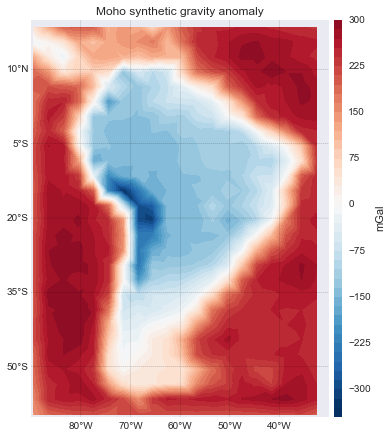

In [18]:
x, y = bm(lon, lat)
ranges = np.abs([data.min(), data.max()]).max()

plt.figure(figsize=(7, 6))
plt.title('Moho synthetic gravity anomaly')
bm.contourf(x, y, data, 60, tri=True, cmap='RdBu_r', vmin=-ranges, vmax=ranges)
plt.colorbar(pad=0.01, aspect=50).set_label('mGal')
bm.drawmeridians(np.arange(-80, -30, 10), labels=[0, 0, 0, 1], linewidth=0.2)
bm.drawparallels(np.arange(-50, 30, 15), labels=[1, 0, 0, 0], linewidth=0.2)
plt.tight_layout()

## Plotting functions

In [19]:
def plot_result_maps(solver, diff=True):
    # Make plots of the data fit, the estimated Moho depth, and the difference 
    # with the true values.
    predicted = solver[0].predicted()
    residuals = solver[0].residuals()
    moho = solver.estimate_
    
    ranges = np.abs([data.max(), data.min()]).max()
    
    plt.figure(figsize=(7, 6))
    plt.title('Observed (color) and predicted (contour) data')    
    levels = mpl.contourf(lon, lat, data, shape, 40, cmap='RdBu_r', basemap=bm, 
                          vmin=-ranges, vmax=ranges)
    plt.colorbar(pad=0.01).set_label('mGal')
    mpl.contour(lon, lat, predicted, shape, levels, basemap=bm, color='#333333')
    bm.drawmeridians(np.arange(-80, -30, 10), labels=[0, 0, 0, 1], linewidth=0.2)
    bm.drawparallels(np.arange(-50, 30, 15), labels=[1, 0, 0, 0], linewidth=0.2)
    plt.tight_layout(pad=0)
    
    plt.figure(figsize=(3, 2.5))
    plt.text(0.65, 0.8, 
             "mean = {:.2f}\nstd = {:.2f}".format(residuals.mean(), residuals.std()), 
             transform=plt.gca().transAxes)
    plt.hist(residuals, bins=20, normed=True, histtype='stepfilled')
    plt.xlabel('Residuals (mGal)')
    plt.ylabel('Normalized frequency')
    plt.tight_layout(pad=0)
    
    x, y = bm(moho.lons, moho.lats)
    
    plt.figure(figsize=(7, 6))
    plt.title("Estimated Moho depth")
    bm.pcolormesh(x, y, -0.001*moho.relief.reshape(moho.shape), cmap='Greens')
    plt.colorbar(pad=0.01).set_label('km')
    bm.drawmeridians(np.arange(-80, -30, 10), labels=[0, 0, 0, 1], linewidth=0.2)
    bm.drawparallels(np.arange(-50, 30, 15), labels=[1, 0, 0, 0], linewidth=0.2)
    plt.tight_layout(pad=0)
    
    if diff:        
        diff = -0.001*(model.relief - moho.relief).reshape(moho.shape)
        ranges = np.abs([diff.max(), diff.min()]).max()

        plt.figure(figsize=(7, 6))
        plt.title("Difference between true and estimated")  
        bm.pcolormesh(x, y, diff, cmap='RdYlBu_r', vmin=-ranges, vmax=ranges)
        plt.colorbar(pad=0.01).set_label('km')
        bm.drawmeridians(np.arange(-40, 45, 20), labels=[0, 0, 0, 1], linewidth=0)
        bm.drawparallels(np.arange(20, 65, 20), labels=[1, 0, 0, 0], linewidth=0)
        plt.tight_layout(pad=0)    

        plt.figure(figsize=(3, 2.5))
        plt.title('true - estimated')
        plt.text(0.65, 0.8, 
                 "mean = {:.2f}\nstd = {:.2f}".format(diff.mean(), diff.std()), 
                 transform=plt.gca().transAxes)
        plt.hist(diff.ravel(), bins=20, normed=True, histtype='stepfilled')
        plt.xlabel('Differences (km)')
        plt.ylabel('Normalized frequency')
        plt.tight_layout(pad=0)

    diff_seismic = -0.001*seismic_residuals(moho, lat_points, lon_points, seismic_points)

    plt.figure(figsize=(3, 2.5))
    plt.title('estimated - seismic')
    plt.text(0.65, 0.8, 
             "mean = {:.2f}\nstd = {:.2f}".format(diff_seismic.mean(), diff_seismic.std()), 
             transform=plt.gca().transAxes)
    plt.hist(diff_seismic, bins=20, normed=True, histtype='stepfilled')
    plt.xlabel('Differences (km)')
    plt.ylabel('Normalized frequency')
    plt.tight_layout(pad=0)

In [198]:
def plot_cv(regul_params, scores, best, log=True): 
    plt.figure(figsize=(5, 3))
    plt.title('Cross-validation (regularization parameter)')
    plt.plot(regul_params, scores, marker='o')
    plt.plot(regul_params[best], scores[best], 's', markersize=10, 
             color=seaborn.color_palette()[2], label='Minimum')
    plt.legend(loc='upper left')
    plt.xscale('log')
    if log:
        plt.yscale('log')
    plt.xlabel('Regularization parameter')
    plt.ylabel(u'Mean Square Error')
    plt.tight_layout(pad=0)
    
def plot_cv_ref_dens(densities, referece_levels, scores, best_dens, best_ref):
    plt.figure(figsize=(5, 3))
    plt.title('Cross-validation (reference level + density)')
    plt.contourf(densities, -0.001*reference_levels, scores, 30, cmap='BuPu_r')
    plt.colorbar(pad=0.01).set_label('Mean Square Error')
    plt.plot(densities[best_dens], -0.001*referece_levels[best_ref], 's', markersize=10, 
             color=seaborn.color_palette()[2], label='Minimum')
    l = plt.legend(loc='upper left')
    for txt in l.get_texts():
        txt.set_color('#ffffff')
    plt.xlabel(u'Density contrast (kg/m³)')
    plt.ylabel('Reference level (km)')
    plt.tight_layout(pad=0)
    
def plot_convergence(solution, log=True):
    plt.figure(figsize=(5, 3))
    plt.title('Convergence')
    plt.plot(range(solution.stats_['iterations'] + 1), solution.stats_['objective'])
    plt.xlabel('Iteration')
    plt.ylabel('Goal function')
    if log:
        plt.yscale('log')
    plt.tight_layout(pad=0)

## Inversion setup

We need to generate a `TesseroidRelief` mesh for the inversion, give it a reference level and a density contrast. We'll assume that our mesh has the same geometry of the true model so that we can better compare the estimated and true Moho reliefs.

In [20]:
mesh = model.copy(deep=True)

In [21]:
mesh = make_mesh(area, shape, reference=reference)

Plane any staring density-contrast on the mesh. This value will be changed during cross-validation.

In [22]:
mesh.addprop('density', np.ones(mesh.size))

We'll also need an initial estimate, the solver and its configuration, and a regularization object.

In [23]:
initial = -60e3*np.ones(mesh.size)  # The initial estimate doesn't really matter too much
misfit = MohoGravityInvSpherical(lat, lon, height, data, mesh)
config = dict(method='newton', initial=initial, tol=0.2, maxit=6)
regul = Smoothness2D(mesh.shape)

## Generate the cross-validation data

In [51]:
test_shape = [int(s*1.2) for s in shape]
print(test_shape)
test_lat, test_lon, test_h = gridder.regular(area, test_shape, z=10e3)
test_data = tesseroid.gz(test_lon, test_lat, test_h, model, njobs=ncpu)
test_set = [test_lat, test_lon, test_h, test_data]

[32, 24]


In [52]:
def score_test_set(model, lat, lon, height, data):
    predicted = tesseroid.gz(lon, lat, height, model)
    score = np.sum((predicted - data)**2)/data.size
    return score

In [53]:
score_test_set(model, *test_set)

0.0

In [54]:
test_data = utils.contaminate(test_data, 5, seed=10)  # Use a different seed to get independent errors

For this test, we'll assume that we don't know the true reference level used or density contrast. We'll try to estimate both through cross-validation. This means that there will be **two levels of cross-validation**: 

1. Testing agains the `test_set` for the regularization parameter
2. Against some other constraints for the reference level and density contrast

These "other constraints" will come some point information about the Moho depth in some isolated points. In reality, these point depths could come from seismic experiments.

We'll generate some fictional point constraints by taking the true value from our Moho model. The point coordinates chosen for this come from the seismic dataset of [Assumpção et al. (2012)](http://dx.doi.org/10.1016%2Fj.tecto.2012.11.014). We'll interpolate the values of the CRUST1 Moho depth onto these points.

In [25]:
lat_points, lon_points = fetch_assumpcao_moho_points('../data/Moho_Map_SAm2013_data.tar.gz')[:2]

In [26]:
seismic_points = gridder.interp_at(model.clat.ravel(), model.clon.ravel(), model.relief, 
                                   lat_points, lon_points)

In [27]:
test_points = [lat_points, lon_points, seismic_points]

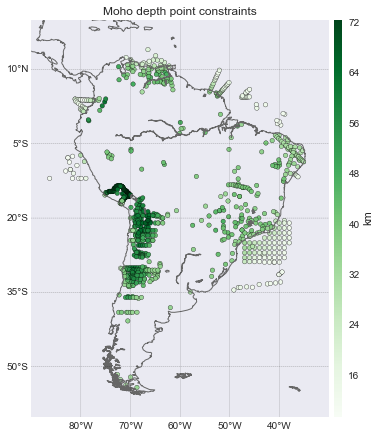

In [28]:
x, y = bm(lon_points, lat_points)

plt.figure(figsize=(7, 6))
plt.title('Moho depth point constraints')
bm.scatter(x, y, c=-0.001*seismic_points, s=20, cmap='Greens')
plt.colorbar(pad=0.01, aspect=50).set_label('km')
bm.drawmeridians(np.arange(-80, -30, 10), labels=[0, 0, 0, 1], linewidth=0.2)
bm.drawparallels(np.arange(-50, 30, 15), labels=[1, 0, 0, 0], linewidth=0.2)
bm.drawcoastlines(color="#666666")
plt.tight_layout()

Now we need a function that, given a Moho depth estimate, will calculate the Mean Square Error (MSE) between that esimate and the "seismic" constraints.

In [29]:
def seismic_residuals(moho, lat, lon, height):
    # moho is the estimated TesseroidRelief object given by
    # solver.estimate_. lat lon and height are the point constraints
    estimated = gridder.interp_at(moho.clat.ravel(), moho.clon.ravel(), moho.relief, 
                                  lat, lon, extrapolate=True)
    return height - estimated
    
def score_seismic_constraints(moho, lat, lon, height):
    residuals = seismic_residuals(moho, lat, lon, height)
    rms = np.sum(residuals**2)/height.size
    return rms

We can check if our function works by feeding it the true model and the extracted points. The MSE should be zero.

In [30]:
score_seismic_constraints(model, lat_points, lon_points, seismic_points)

0.0

Now we need functions to perform the second level of cross-validation to find the reference levels and (optionally) the density constrast.

In [186]:
def _fit_score(params):
    # Need to unpack the configuration for this run
    # from the dictionary. This is because multiprocessing.Pool.map
    # only allows me to pass a single argument to the function.
    args = params['args']
    misfit = args['misfit']
    regul = args['regul']
    regul_params = args['regul_params']
    config = args['config']
    test_set = args['test_set']    
    test_points = args['test_points']    
    # Configure the solver to use the specified density
    # and reference level
    misfit.set_density(params['density'])
    misfit.set_reference(params['reference'])
    # Run the inversion for each value of the regularization
    # parameter. Each run gets a score based on the misfit
    # to the test dataset and the seismic point contraints.
    # The try...except block is catch any error that might
    # occur. This stops the whole cross-validation process from
    # shutting down because of an error. The solution is marked
    # as None so that we know there is a problem.
    solutions = []
    regul_scores = []
    scores = []
    for mu in regul_params:
        try:
            solution = (misfit + mu*regul).config(**config).fit()
            regul_score = score_test_set(solution.estimate_, *test_set)
            score = score_seismic_constraints(solution.estimate_, *test_points)
        except:
            solution = None
            regul_score = np.nan
            score = np.nan
        solutions.append(solution)
        regul_scores.append(regul_score)
        scores.append(score)
    return scores, regul_scores, solutions
    
def cross_validation(misfit, regul, regul_params, references, densities, config, test_set, test_points, njobs=1): 
    args = dict(misfit=misfit, regul=regul, regul_params=regul_params, 
                config=config, test_set=test_set, test_points=test_points)
    # Put all the arguments need to for each inversion run into 
    # dictionaries. Each element of the list is the configuration
    # for run. Columns are density, rows are reference level.
    cvmatrix = [[dict(density=dens, reference=ref, args=args) 
                 for dens in densities]
                for ref in references]
    if njobs > 1:
        pool = multiprocessing.Pool(njobs)
        # itertools.chain flattens the cvmatrix
        results = pool.map(_fit_score, itertools.chain(*cvmatrix))
        pool.close()
        pool.join()
    else:
        results = map(_fit_score, itertools.chain(*cvmatrix))
    scores, regul_scores, solutions = zip(*results)
    # Transforms the list of solutions into a 3D "array" with shape
    shape = (len(references), len(densities), len(regul_params))
    solutions = zip(*[iter(solutions)]*len(densities))
    scores = np.array(scores).reshape(shape)
    regul_scores = np.array(regul_scores).reshape(shape)
    return scores, regul_scores, solutions

def take_best(scores, regul_scores, solutions):
    # All arguments are 3D arrays. The dimensions are:
    #   reference level, density, regularization parameter 
    # Get the best according to regul_scores for each
    # reference level and density
    best_by_regul = np.nanargmin(regul_scores, axis=2)
    # Get the best of 'scores' correspoding to the best regularization parameters
    scores_matrix = np.take(scores, best_by_regul)
    # Find the index of the best parameters
    best_ref, best_dens = np.unravel_index(np.nanargmin(scores_matrix), best_by_regul.shape)
    best_regul = best_by_regul[best_ref, best_dens]
    regul_scores_of_best = regul_scores[best_ref, best_dens, :]
    solution = solutions[best_ref][best_dens][best_regul]
    return best_ref, best_dens, best_regul, solution, scores_matrix, regul_scores_of_best

## Run the cross-validation

These are the values of the regularization parameter, reference level, and density contrast that we'll use.

In [143]:
regul_params = np.logspace(-7, -2, 6)
regul_params

array([  1.00000000e-07,   1.00000000e-06,   1.00000000e-05,
         1.00000000e-04,   1.00000000e-03,   1.00000000e-02])

In [200]:
reference_levels = np.arange(-35e3, -20e3, 2500)
reference_levels

array([-35000., -32500., -30000., -27500., -25000., -22500.])

In [201]:
densities = np.arange(200, 500, 50)
densities

array([200, 250, 300, 350, 400, 450])

In [202]:
args = [misfit, regul, regul_params, reference_levels, densities, config, test_set, test_points, ncpu]
%time results = cross_validation(*args)

CPU times: user 592 ms, sys: 237 ms, total: 829 ms
Wall time: 4min 49s


Save the results to a Python pickle file to use later without having to re-compute (in case we need to come back and work on the plots).

In [ ]:
#with open('synthetic-crust1-south-america-single-density.pickle', 'w') as f:
#    pickle.dump(results, f)

Unpack the results and make plots.

In [203]:
best_ref, best_dens, best_regul, solution, scores, regul_scores = take_best(*results)

In [204]:
reference_levels[best_ref]

-35000.0

In [205]:
densities[best_dens]

250

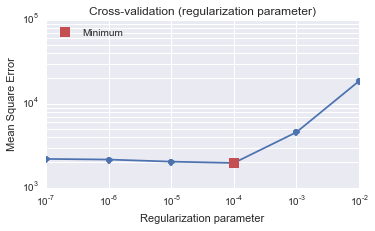

In [206]:
plot_cv(regul_params, regul_scores, best_regul, log=True)
plt.grid(True, which='both', axis='y')

In [208]:
scores

array([[  3.52108269e+08,   1.34108450e+08,   1.34108450e+08,
          1.34108450e+08,   1.34108450e+08,   1.34108450e+08],
       [  3.13773711e+08,   1.34108450e+08,   1.34108450e+08,
          1.34108450e+08,   1.34108450e+08,   1.34108450e+08],
       [  3.13773711e+08,   1.34108450e+08,   1.34108450e+08,
          1.34108450e+08,   1.34108450e+08,   1.34108450e+08],
       [  3.13773711e+08,   3.52108269e+08,   1.34108450e+08,
          1.34108450e+08,   1.34108450e+08,   1.34108450e+08],
       [  3.13773711e+08,   3.52108269e+08,   1.34108450e+08,
          1.34108450e+08,   1.34108450e+08,   1.34108450e+08],
       [  3.13773711e+08,   3.13773711e+08,   1.34108450e+08,
          1.34108450e+08,   1.34108450e+08,   1.34108450e+08]])

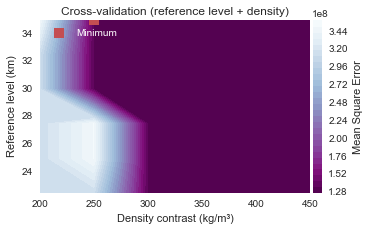

In [207]:
plot_cv_ref_dens(densities, reference_levels, scores, best_dens, best_ref)

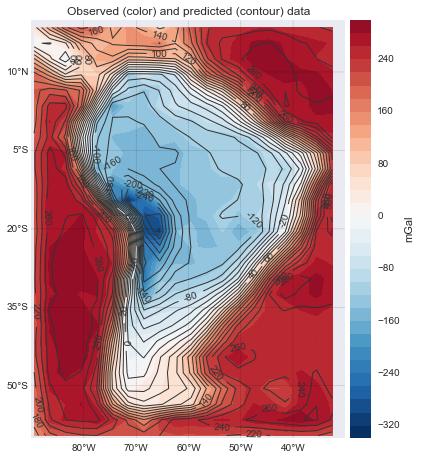

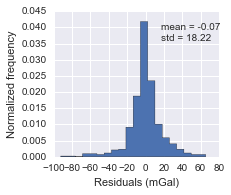

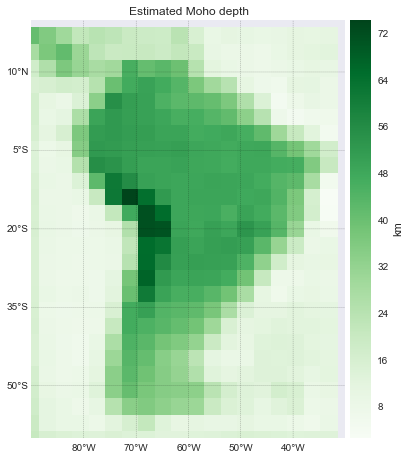

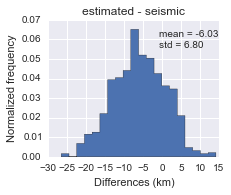

In [211]:
plot_result_maps(solution, diff=False)